In [77]:
import numpy as np
from matplotlib import pyplot as plt 
%matplotlib inline 
import os 
from statsmodels.stats import multitest

statspath = '/home/nfarrugi/datasets/mpi_pd_cueing/results/'

Step 0 - preparing data 

fields for the saved stats files are : 
- scores
- proba
- pval
- U

For each of them, layout is 4 (Regreg,RegIrreg,IrregReg,IrregIrreg) x CV x TestTime x TrainTime

In [4]:
allsubj = os.listdir(statspath)

Statistical analyis from [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3903480/)
--
To compute the average duration over which temporal generalization remained significant, we computed the number of time samples during which each classifier could significantly predict the trials' classes, using false discovery rate (FDR) to correct for multiple comparison. To avoid underestimating the mean generalization time, we only considered the time window during which the diagonal classifiers performed above chance (82 ms–450 ms).

Statistics & Effect sizes
To test for statistical significance within subjects, Mann-Whitney U tests were performed on the classifiers' continuous outputs, with trials as the random variable. Similarly, across-subjects statistics were performed using Wilcoxon Signed Rank Tests. Effect sizes are summarized with the AUC computed from empirical ROC analyses. An AUC of 50% implies that true positive predictions (e.g. trial was correctly predicted to belong to class α) and false positive predictions (e.g. trial was erroneously predicted to belong to class α) are, on average, equally probable; an AUC of 100% indicates a perfect prediction with no false positives. In principle, for the diagonal decoding, classification performance should not yield AUCs that are significantly below 50%. However, when a classifier fitting and testing time differ, AUCs can be significantly below 50%, as the pattern of brain activation carrying the discriminative information can be flipped in sign between t and t′. Statistical analyses were performed with MATLAB 2009b.

Two common yet important statistical points may be worth noting here. First, statistical significance (i.e. p-value) is related but distinct from classification performance (i.e. AUC). Indeed, while the former indicates whether the test is likely to reflect a non-random result (i.e. “Is there decodable information?”), the latter indicates the extent to which each trial can be classified from MEG signals (i.e. “How much information is there?”). Second, the use of non-parametric statistical methods was motivated by the non-Gaussian distribution of our data (see [11]'s supplementary materials).

other [paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5635957/)
--
ROC analyses and AUCs are methods to estimate the size of a given effect, and in our case, the classifiers' ability to discriminate two types of trials. To test for statistical significance within subjects, we performed Mann–Whitney U tests across trials. Because the classifier attributes a continuous estimate to each trial (its predicted probability of belonging to a given class C), we can indeed efficiently compare those predicted probabilities across the two levels of the trials' true classes. For instance, for each trial, the classifier outputs a predicted probability of belonging to the standard class (S). Note that the probability of belonging to the other, deviant class (D) can be calculated as P(D) = 1 − P(S). We can then compare the predicted probability of belonging to S depending on whether the trials truly are standard (y = S) or not (y = D) and thus apply a traditional Mann–Whitney U Test between P(S|y = S) and P(S|y = D).

Similarly, across-subjects statistics were performed using Wilcoxon Signed Rank Tests based on the mean predicted probability conditional of trials' true classes. For each subject, the predicted probability of belonging to the standard class (S) is averaged across standard trials (y = S) and, separately, over deviant trials (y = D), yielding P(S|y = S) and P(S|y = D). For each subject i, we can thus compute the sum of positive ranks and perform a Wilcoxon test. A correction for multiple comparisons, either across classifiers or across subjects, was performed using the standard False Discovery Rate (FDR) correction, and is hereafter referred to as pFDR.

In [5]:
allsubj

['180802_03c3_formal_conditionwise.npz',
 '180802_10c2_formal_conditionwise.npz',
 '180802_04k1_formal_conditionwise.npz',
 '180802_13k1_formal_conditionwise.npz',
 '180802_05k1_formal_conditionwise.npz',
 '180802_12c1_formal_conditionwise.npz',
 '180802_11c2_formal_conditionwise.npz',
 '180802_06k1_formal_conditionwise.npz',
 '180802_15c1_formal_conditionwise.npz',
 '180802_07c1_formal_conditionwise.npz',
 '180802_17c1_formal_conditionwise.npz',
 '180802_20k1_formal_conditionwise.npz',
 '180802_05c2_formal_conditionwise.npz',
 '180802_17c2_formal_conditionwise.npz',
 '180802_11c1_formal_conditionwise.npz',
 '180802_03m1_formal_conditionwise.npz',
 '180802_05c1_formal_conditionwise.npz',
 '180802_09k1_formal_conditionwise.npz',
 '180802_08k1_formal_conditionwise.npz',
 '180802_14c1_formal_conditionwise.npz',
 '180802_13c3_formal_conditionwise.npz',
 '180802_02k1_formal_conditionwise.npz',
 '180802_12k1_formal_conditionwise.npz',
 '180802_04c1_formal_conditionwise.npz',
 '180802_11k1_fo

Group files per subject type (patients or control) 

In [6]:
controls_id = []
patients_id = []

for cursubj in allsubj:
    if (cursubj[9]=='k'):
        controls_id.append(cursubj)
    else:
        if cursubj[10]=='1':
            patients_id.append(cursubj)
            

In [7]:
len(patients_id)

19

Step 1 - Analysis of "Diagonal" Classification

We average the diagonal of the p values of the within-subjects Mann Whittney U-Test, and average them across CV folds. We correct the resulting p values using FDR Benjamin Hochberg correction, and sum the resulting vectors across all subjects. 

We also compute an uncorrected version with a threshold of $p < 0.01$

In [47]:
def diagonal_group(subjlist,statspath,thresh_unc = 0.01,timevec=None,showall=False,threshold_zeros=40,doplots=True,keepall=True):


    if (showall):
        print("Showing all subjects")
    else:
        print("Showing subjects with less than %d FDR significant points" % threshold_zeros)
    
    diag_sig_fdr_all = []
    diag_sig_unc_all = []
    diag_ROC_all = []
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curroc = np.load(cursubj)['scores'].mean(axis=1)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([np.diag(curmat) for curmat in curpvals]) # extract diagonal classification

        diag_ROC = np.stack([np.diag(curmat) for curmat in curroc]) # extract diagonal classification
        
        
        diag_sig_fdr = []
        diag_sig_unc = []
        for curdiag in diag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            H_unc = curdiag < thresh_unc
            diag_sig_unc.append(H_unc)
            diag_sig_fdr.append(H)

        nonzeros = np.sum(np.stack(diag_sig_fdr))
        if showall:
            print("Subj %s number of non-zeros FDR : %d " %(subj,nonzeros))
                        
        elif nonzeros < threshold_zeros:
            print("Subj %s has zero or few significant FDR : %d " %(subj,nonzeros))
            
            if (nonzeros >= 0 ) and doplots:
                #plt.subplot(1,2,1)
                plt.plot(timevec,diag_sig_fdr[0])
                #plt.subplot(1,2,2)
                plt.plot(timevec,diag_ROC[0])
                plt.show()
            
        
        #print("Subj %s number of non-zeros Uncorrected : %d " %(subj,np.sum(np.stack(diag_sig_unc))))
        
        if (nonzeros > threshold_zeros) or keepall:
            diag_sig_fdr_all.append(np.stack(diag_sig_fdr))
            diag_sig_unc_all.append(np.stack(diag_sig_unc))
            diag_ROC_all.append(diag_ROC)

    
    return np.sum(np.stack(diag_sig_fdr_all),axis=0),np.sum(np.stack(diag_sig_unc_all),axis=0),np.stack(diag_ROC_all)

In [66]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False)

Showing subjects with less than 40 FDR significant points
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 1 
Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 30 
Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 37 
Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 38 
Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 18 
Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17c1_formal_conditionwise.npz has zero or few significant FDR : 2 
Subj 180802_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_04c1_formal_conditionwise.npz has zero or few significant FDR : 7 
Subj 180802

5 controls and 10 patients don't have enough decodable information in "diagonal decoding", which informally means that when training a classifier to discriminate between standard and deviants, at one specific time point (=thus "diagonal" decoding), the estimated probabilities of each trial being classified as either a standard or a deviant cannot be reliably distinguished (as shown by a lack of significance in a Mann-Whitney U-test). 


Uncomment the following cell to output number of FDR corrected Mann Whitney whithin subjects statistics for all subjects (to give an idea how many signficant values we get for the ones who work well)

In [73]:
#diag_sig_fdr_controls,diag_sig_unc_controls,_ = diagonal_group(controls_id,statspath,0.05,showall=True)
#diag_sig_fdr_patients,diag_sig_unc_patients,_ = diagonal_group(patients_id,statspath,0.05,showall=True)

Uncomment the following cell to just plot the sum of significant Mann Wittney subjects as a function of time (FDR corrected) 

In [74]:
#four_plots(timevec,subtitles,diag_sig_fdr_controls,'Controls - FDR')

In [75]:
#four_plots(timevec,subtitles,diag_sig_fdr_patients,'Patients')

Uncomment the following lines to look at the same counts without FDR correction

In [21]:
#four_plots(timevec,subtitles,diag_sig_unc_controls,'Controls-unc')

In [22]:
#four_plots(timevec,subtitles,diag_sig_unc_patients,'Patients unc')


We can examine the ROC AUC scores for the same subjects, to check whether this phenomenon has anything to do with classification performance (it should!). For that, we overlay the FDR-corrected timewise significance of the Mann-Whitney U-test with the ROC AUC performance of the problematic subjects

In [10]:
tmin = -0.05
tmax = 0.52

timevec = np.linspace(tmin,tmax,diag_sig_fdr_controls.shape[1])

Showing subjects with less than 40 FDR significant points
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 1 


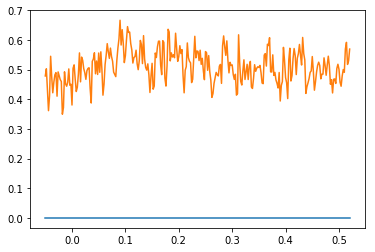

Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 30 


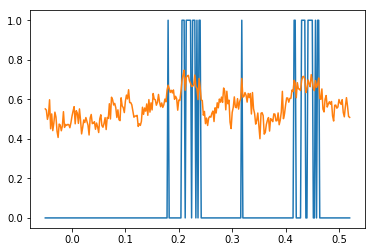

Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 37 


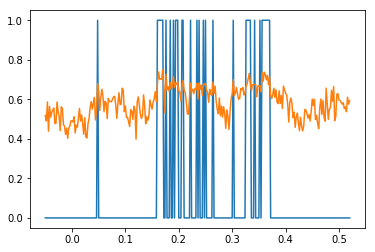

Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 38 


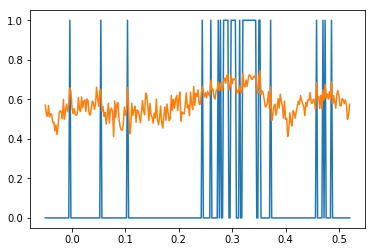

Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 18 


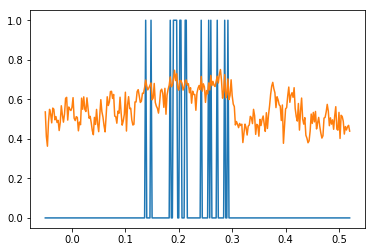

Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 


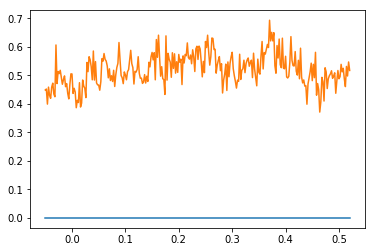

Subj 180802_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 


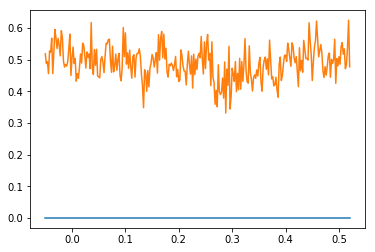

Subj 180802_17c1_formal_conditionwise.npz has zero or few significant FDR : 2 


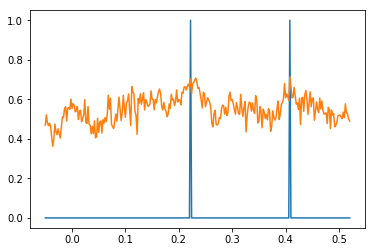

Subj 180802_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 


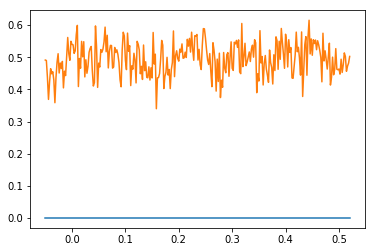

Subj 180802_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 


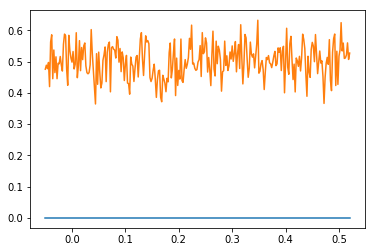

Subj 180802_04c1_formal_conditionwise.npz has zero or few significant FDR : 7 


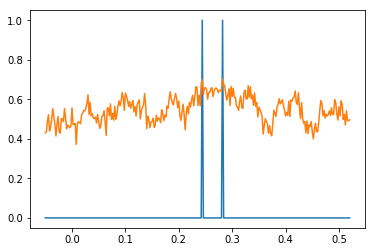

Subj 180802_01m1_formal_conditionwise.npz has zero or few significant FDR : 22 


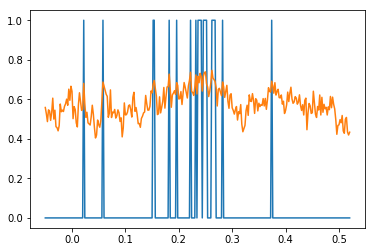

Subj 180802_09c1_formal_conditionwise.npz has zero or few significant FDR : 2 


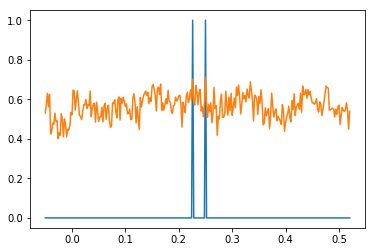

Subj 180802_08c1_formal_conditionwise.npz has zero or few significant FDR : 9 


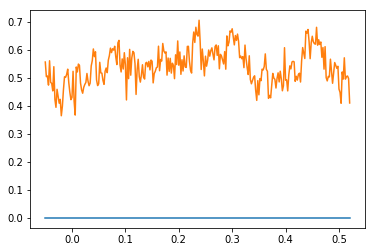

Subj 180802_04m1_formal_conditionwise.npz has zero or few significant FDR : 3 


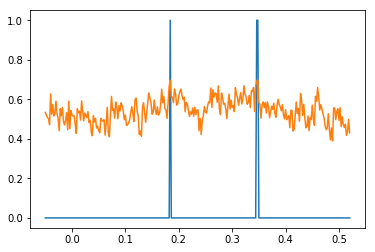

In [65]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,timevec=timevec,doplots=True)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,timevec=timevec,doplots=True)

Bottomline : the very few points corresponding to significant Mann Wittney test are around 0.7 AUC score, which is indeed indicative of a nonreliable classification performance. 
In the following, we will consider AUC less than 0.7 as "non significant classification". 

To illustrate this at the group level, let's now plot the average and std of ROC AUC for the whole groups. 

In [12]:
subtitles = ['Train Regular Test Regular',
            'Train Regular Test Irregular',
            'Train Irregular Test Regular',
            'Train Irregular Test Irregular']

In [13]:
def four_plots(timevec,subtitles,diag_sig,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,diag_sig[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

In [60]:
def four_errorplots(timevec,subtitles,diag_roc,mytitle):
    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.errorbar(timevec,diag_roc[:,i-1,:].mean(axis=0),yerr=diag_roc[:,i-1,:].std(axis=0),errorevery=5)
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

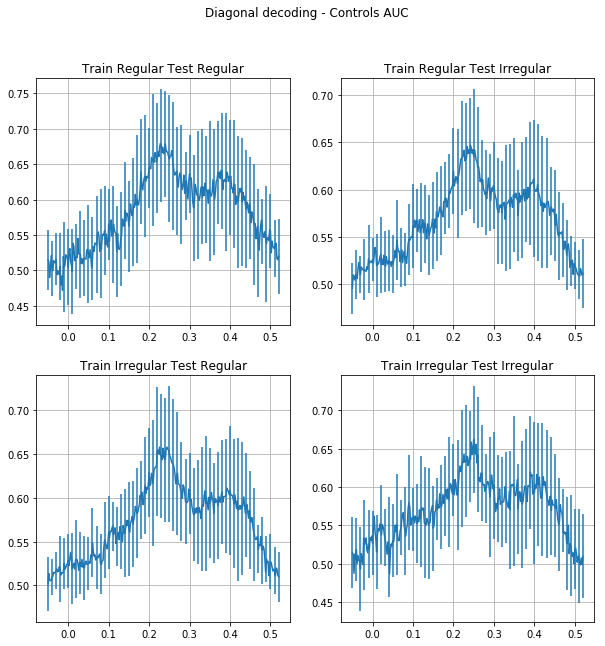

In [67]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')

We can deduce from this plot that for the control group, the time window between 200 and 250 ms seem to yield the most significant decoding across controls. This can be seen on the "Train Regular, Test Regular" condition, as well as the "train irregular, test irregular" condition, which are the two cases for which the classifier was trained. The other cases correspond to how well the classifier generalizes across conditions. We will test this aspect later in the report. 

For patients :

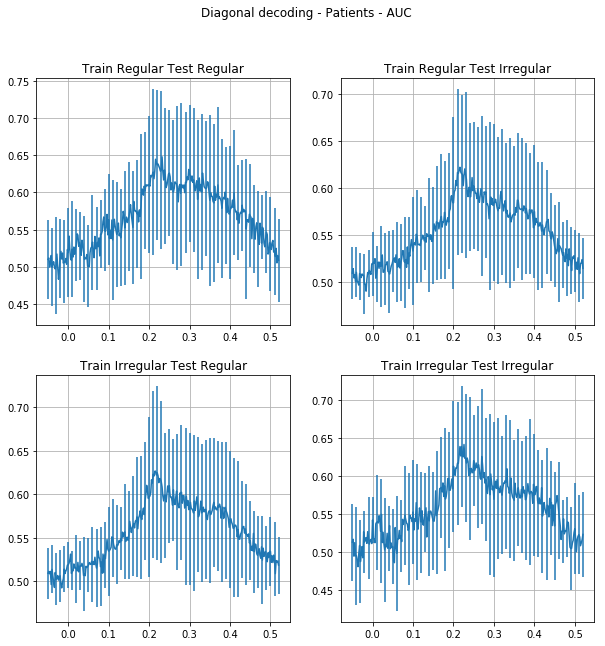

In [69]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')


Remember that 10 patients didn't have any significant classification, which explains the very high variability here. 

Let's see what happens on ROC if we don't include the data for which there is few FDR individual significance of Mann Whitnney. The next cell gathers all subjects data by rejecting subjects who don't pass the FDR significance with at least 40 points

In [70]:
diag_sig_fdr_controls,diag_sig_unc_controls,diag_ROC_controls = diagonal_group(controls_id,statspath,0.05,doplots=False,keepall=False)
diag_sig_fdr_patients,diag_sig_unc_patients,diag_ROC_patients = diagonal_group(patients_id,statspath,0.05,doplots=False,keepall=False)

Showing subjects with less than 40 FDR significant points
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 1 
Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 30 
Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 37 
Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 38 
Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 18 
Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17c1_formal_conditionwise.npz has zero or few significant FDR : 2 
Subj 180802_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_04c1_formal_conditionwise.npz has zero or few significant FDR : 7 
Subj 180802

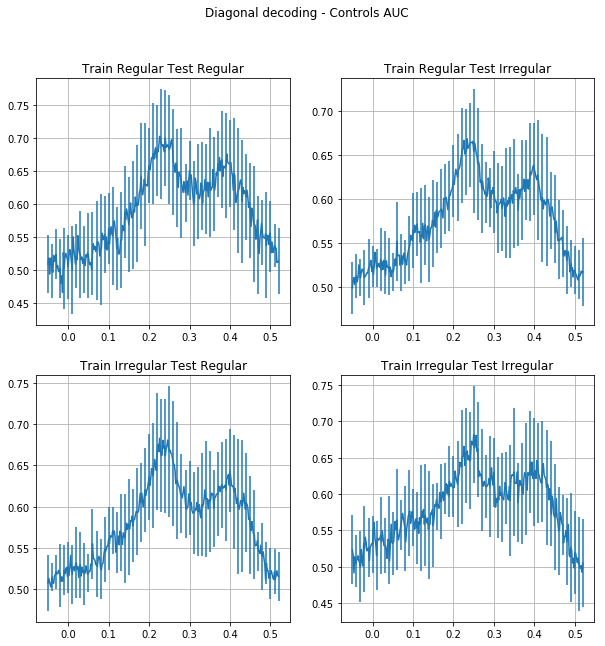

In [71]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_controls,mytitle='Controls AUC')

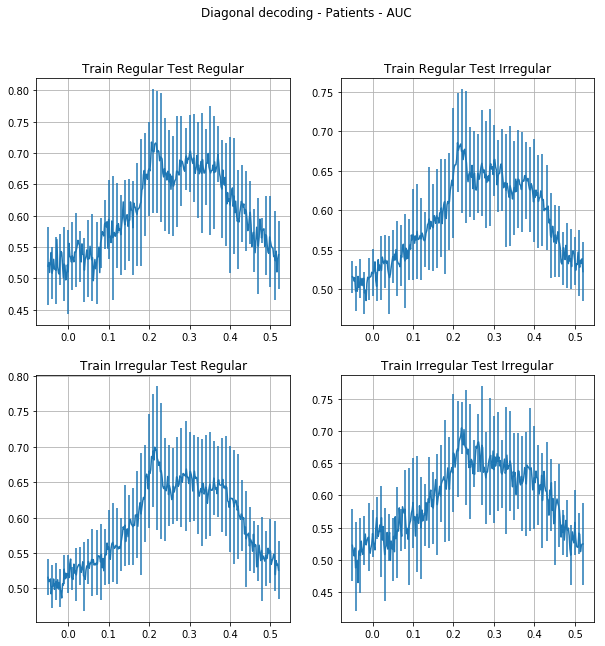

In [72]:
four_errorplots(timevec,subtitles,diag_roc=diag_ROC_patients,mytitle='Patients - AUC')

Let's have a look at the averages only, but superimposing patients and controls on the same plots, zooming in on the region 200ms to 400 ms. 

We will superimpose the result of an independent t-test at each time point, between groups

In [155]:
from scipy.stats import ttest_ind

def twogroups_fourplots(timevec,subtitles,diag_roc1,diag_roc2,mytitle,tstart=None,tend=None,ttest=False):
    plt.figure(figsize=(10,10))

    ngroup1 = diag_roc1.shape[0]
    ngroup2 = diag_roc2.shape[0]
    
    if tstart is None:
        tstart=0
    if tend is None:
        tend=timevec.shape[0]
    
    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec[tstart:tend],diag_roc1[:,i-1,tstart:tend].mean(axis=0))
        plt.plot(timevec[tstart:tend],diag_roc2[:,i-1,tstart:tend].mean(axis=0))
        
        if ttest:
            
            
            tstat,p_unc = ttest_ind(a=diag_roc1[:,i-1,tstart:tend],b=diag_roc2[:,i-1,tstart:tend],equal_var=True)
            
            timevec_sub = timevec[tstart:tend]
            H = (p_unc<0.05)
            sig_ind = timevec_sub[H]
            sig= np.ones_like(sig_ind)*0.7
            
            #FDR correction            
            #H,p_fdr,_,_=multitest.multipletests(p_unc,method='fdr_bh')
            
            plt.plot(sig_ind,sig,'*')
            
            
        plt.title(subtitles[i-1])
        plt.grid(True)
    plt.legend(['controls (n=%d)' % ngroup1,'patients (n=%d)' % ngroup2,'ttest uncorr.'],loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.suptitle('Diagonal decoding - %s' % mytitle)
    plt.show()

this is for only the "good" participants (high SnR) 

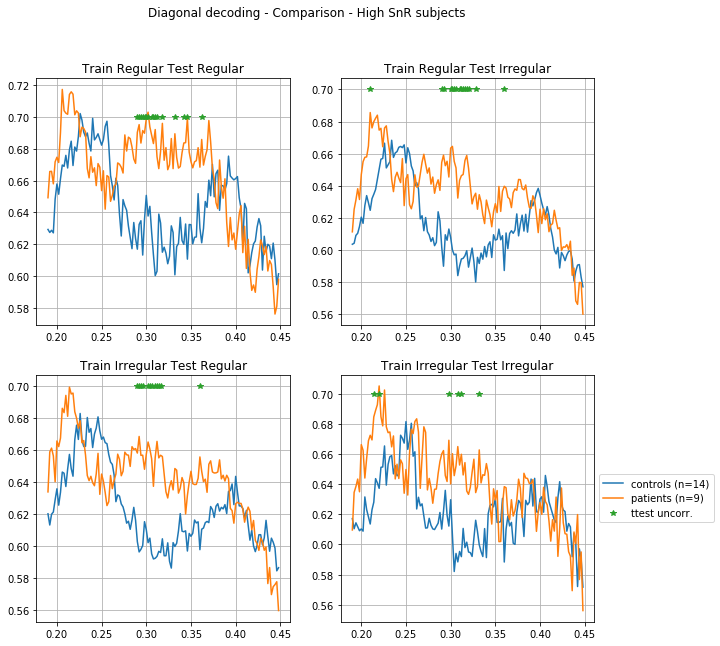

In [157]:
twogroups_fourplots(timevec,subtitles,diag_ROC_controls,diag_ROC_patients,'Comparison - High SnR subjects',tstart=120,tend=250,ttest=True)

and this is for all participants 

Showing subjects with less than 40 FDR significant points
Subj 180802_02k1_formal_conditionwise.npz has zero or few significant FDR : 1 
Subj 180802_11k1_formal_conditionwise.npz has zero or few significant FDR : 30 
Subj 180802_15k1_formal_conditionwise.npz has zero or few significant FDR : 37 
Subj 180802_17k1_formal_conditionwise.npz has zero or few significant FDR : 38 
Subj 180802_18k1_formal_conditionwise.npz has zero or few significant FDR : 18 
Showing subjects with less than 40 FDR significant points
Subj 180802_12c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_15c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_17c1_formal_conditionwise.npz has zero or few significant FDR : 2 
Subj 180802_11c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_14c1_formal_conditionwise.npz has zero or few significant FDR : 0 
Subj 180802_04c1_formal_conditionwise.npz has zero or few significant FDR : 7 
Subj 180802

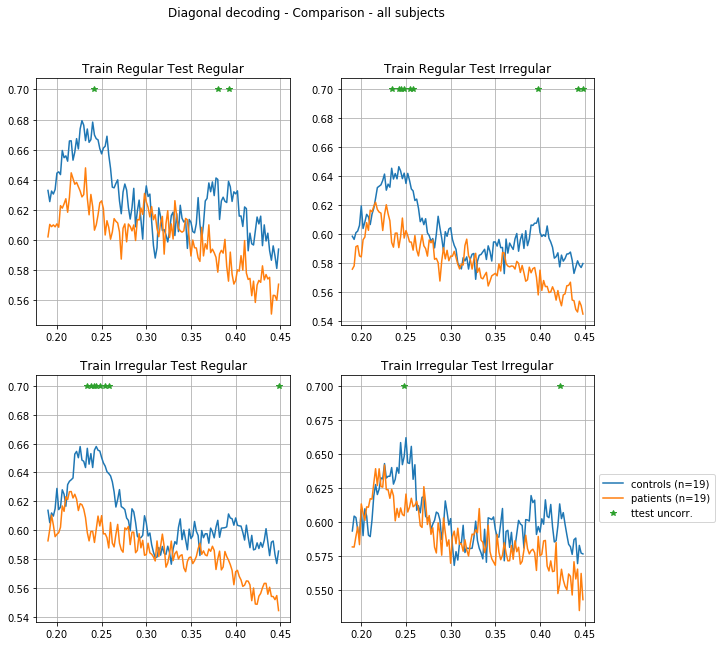

In [158]:
_,_,diag_ROC_controls_all = diagonal_group(controls_id,statspath,0.05,doplots=False,keepall=True)
_,_,diag_ROC_patients_all = diagonal_group(patients_id,statspath,0.05,doplots=False,keepall=True)
twogroups_fourplots(timevec,subtitles,diag_ROC_controls_all,diag_ROC_patients_all,'Comparison - all subjects',tstart=120,tend=250,ttest=True)

Unfortunately these differences didn't survive FDR correction, so we can't reliably interpret this as a group difference. 

Between-subject statistics of estimated class probabilities
--

In [71]:
from scipy.stats import wilcoxon

In [67]:
wilcoxon?

Signature: wilcoxon(x, y=None, zero_method='wilcox', correction=False)
Docstring:
Calculate the Wilcoxon signed-rank test.

The Wilcoxon signed-rank test tests the null hypothesis that two
related paired samples come from the same distribution. In particular,
it tests whether the distribution of the differences x - y is symmetric
about zero. It is a non-parametric version of the paired T-test.

Parameters
----------
x : array_like
    The first set of measurements.
y : array_like, optional
    The second set of measurements.  If `y` is not given, then the `x`
    array is considered to be the differences between the two sets of
    measurements.
zero_method : string, {"pratt", "wilcox", "zsplit"}, optional
    "pratt":
        Pratt treatment: includes zero-differences in the ranking process
        (more conservative)
    "wilcox":
        Wilcox treatment: discards all zero-differences
    "zsplit":
        Zero rank split: just like Pratt, but spliting the zero rank
        between 

In [101]:
def betweensubjects_diag(subjlist,statspath):
    
    wilcox_Z_all = []
    wilcox_p_all = []
    
    proba_std_all = []
    proba_dev_all = []
    
    H_all = []

    wilcox_pfdr_all = []
    
    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curproba = np.load(cursubj)['proba'].mean(axis=1)
        
        diag_proba_std = np.stack([np.diag(curmat) for curmat in curproba[:,0]]) # extract diagonal classification
        diag_proba_dev = np.stack([np.diag(curmat) for curmat in curproba[:,1]]) # extract diagonal classification
        
        proba_std_all.append(diag_proba_std)
        proba_dev_all.append(diag_proba_dev)
            
    proba_std_all = np.stack(proba_std_all)
    proba_dev_all = np.stack(proba_dev_all)
    
    
    nsub,nrep,ntime = proba_std_all.shape
    
    
    for i in range(nrep):
        p_rep = []
        for j in range(ntime):
            z,p = wilcoxon(x=proba_std_all[:,i,j].ravel(),y=proba_dev_all[:,i,j].ravel())
            
            wilcox_Z_all.append(z)
            p_rep.append(p)
            
        p_rep = np.stack(p_rep)
        
        wilcox_p_all.append(p_rep)
        
        H,pfdr,_,_=multitest.multipletests(p_rep,method='fdr_bh')
        
        H_all.append(H)
        wilcox_pfdr_all.append(pfdr)
        
    #print(proba_all.shape)
    
    return np.reshape(np.stack(wilcox_Z_all),(nrep,ntime)),np.reshape(np.stack(wilcox_p_all),(nrep,ntime)),np.reshape(np.stack(wilcox_pfdr_all),(nrep,ntime)),np.reshape(np.stack(H_all),(nrep,ntime))

In [102]:
allZ_controls, all_Punc_controls,all_Pfdr_controls,wilcox_H_controls = betweensubjects_diag(controls_id,statspath)
allZ_patients, all_Punc_patients,all_Pfdr_patients,wilcox_H_patients = betweensubjects_diag(patients_id,statspath)

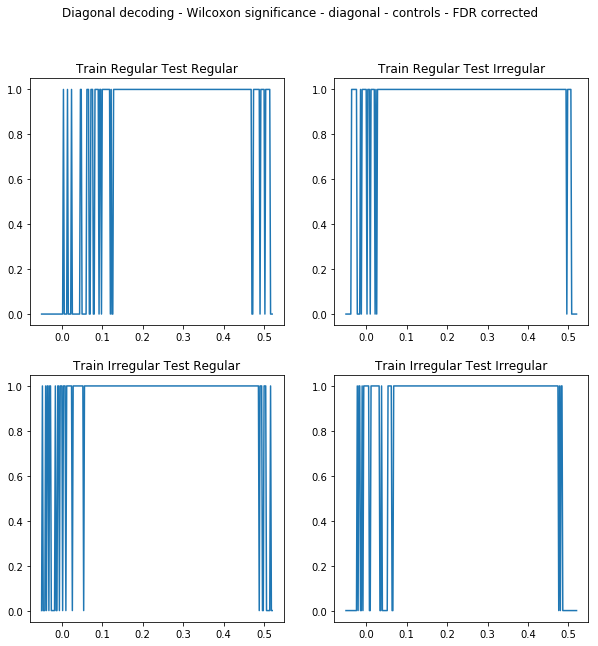

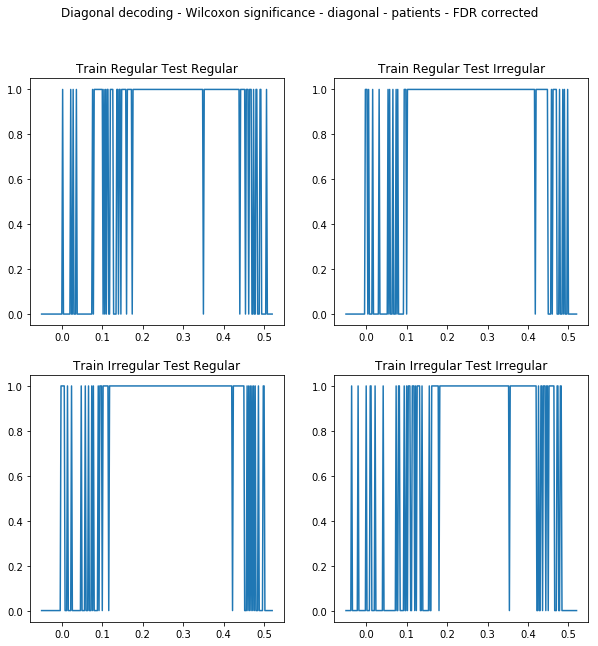

In [107]:
four_plots(timevec,subtitles,wilcox_H_controls,'Wilcoxon significance - diagonal - controls - FDR corrected')
four_plots(timevec,subtitles,wilcox_H_patients,'Wilcoxon significance - diagonal - patients - FDR corrected')

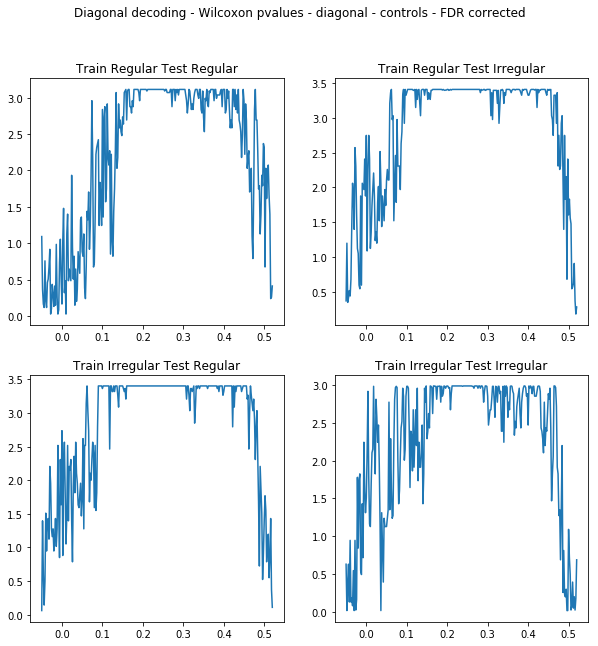

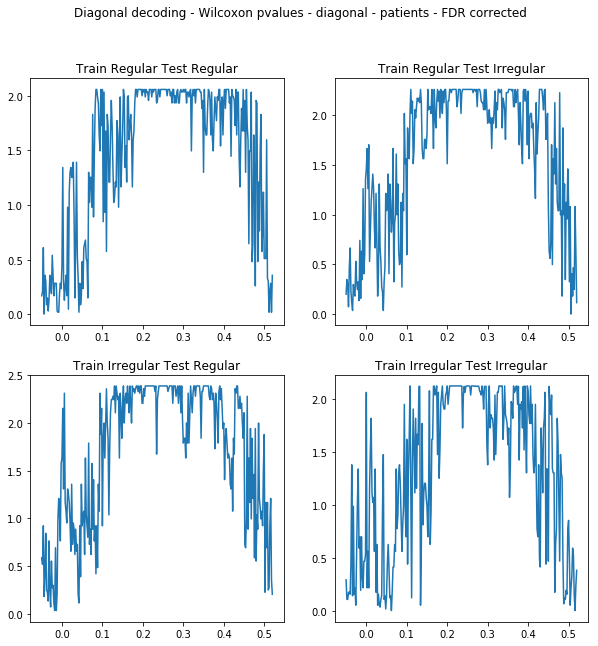

In [108]:
four_plots(timevec,subtitles,-np.log10(all_Pfdr_controls),'Wilcoxon pvalues - diagonal - controls - FDR corrected')
four_plots(timevec,subtitles,-np.log10(all_Pfdr_patients),'Wilcoxon pvalues - diagonal - patients - FDR corrected')

Step 2 - Average duration of significant generalization

Objective : find a reasonable min / max time window in which diagonal classification is significant for most subjects. 

In the time window for which diagonal classification is significant for most, investigate every 100 ms whether there is temporal generalization. 

In [37]:
def offdiagonal_group(subjlist,statspath,timepoint):


    for subj in subjlist:
        cursubj = os.path.join(statspath,subj)
        curpvals = np.load(cursubj)['pval'].mean(axis=1) # Calculating mean p-value accross CV splits 
        diag_pvals = np.stack([curmat[timepoint,:] for curmat in curpvals]) # extract a line from the matrix 

        diag_sig_fdr = []
        for curdiag in diag_pvals:
            H,p,_,_=multitest.multipletests(curdiag,method='fdr_bh')
            diag_sig_fdr.append(H)

        return np.stack(diag_sig_fdr)

In [65]:
tp=0.300
tp_ind = 175
### Find the index corresponding to this timepoint 
print(timevec[tp_ind])

0.3


In [76]:
tp_ind2 = 225
### Find the index corresponding to this timepoint 
print(timevec[tp_ind2])

0.4


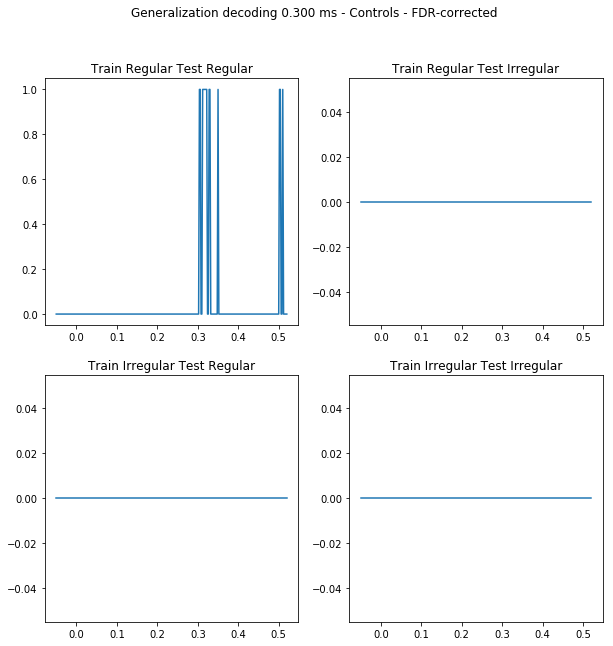

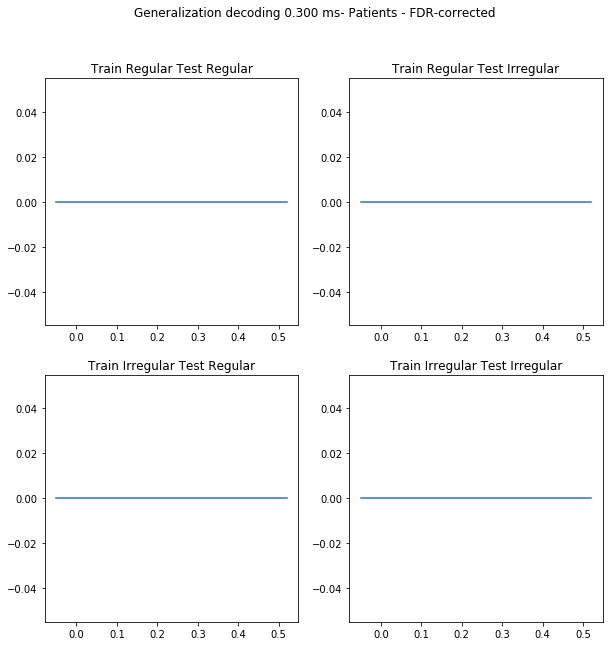

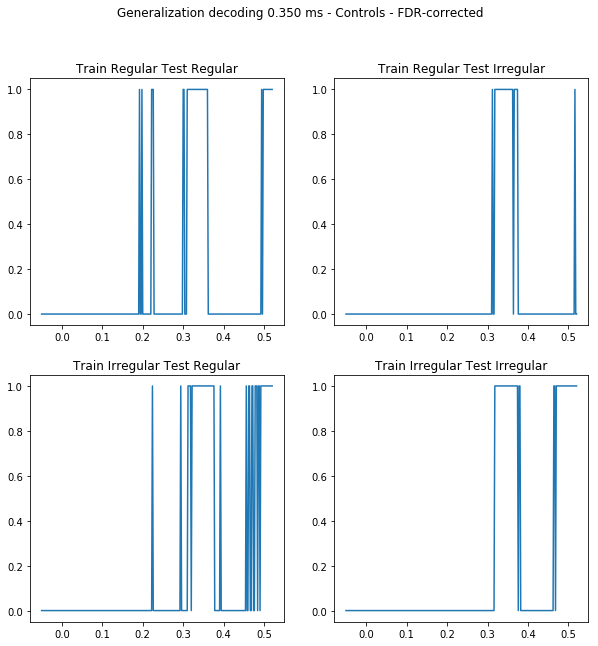

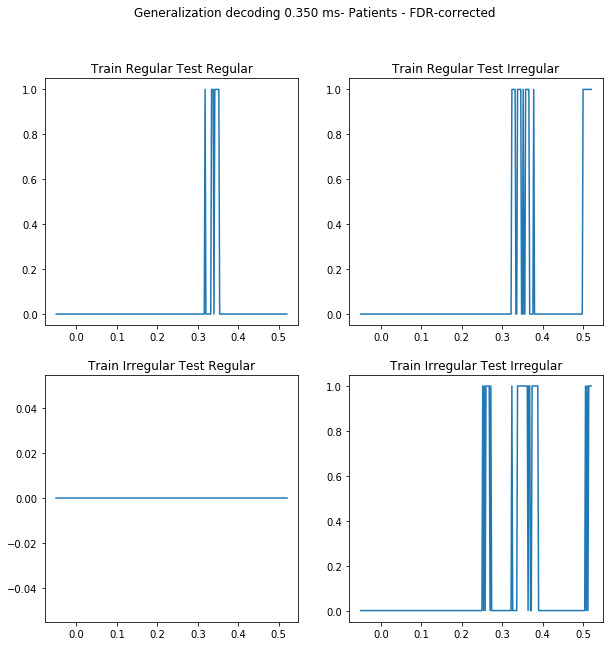

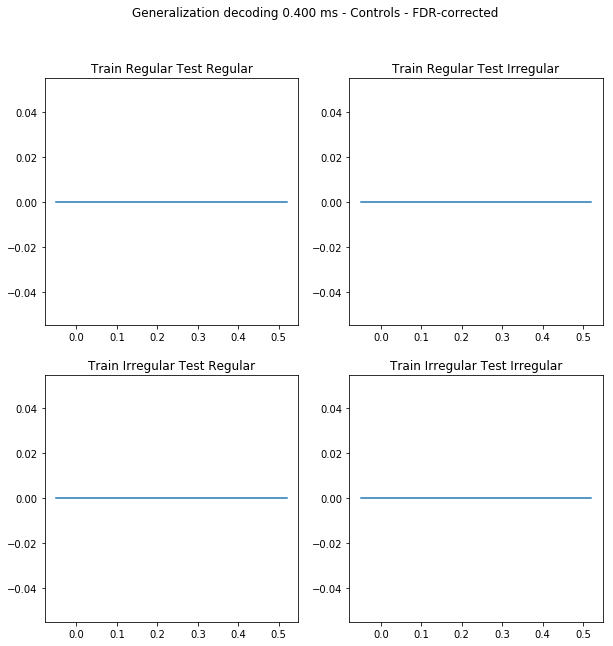

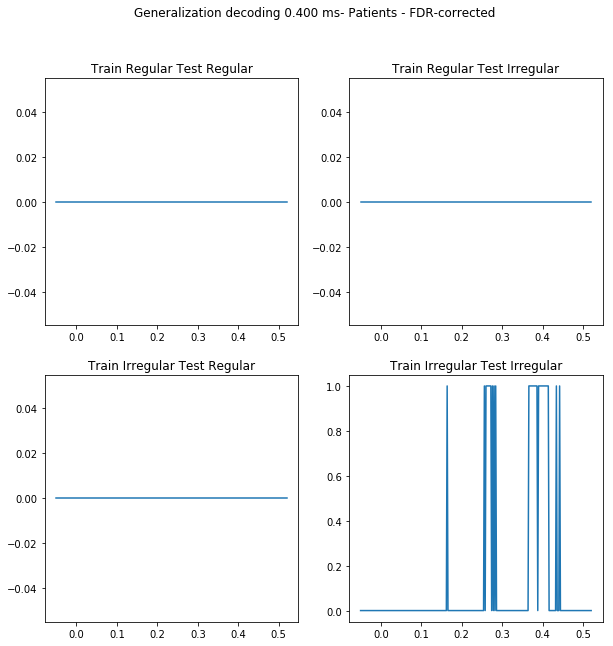

In [77]:
for curtp_ind in [175,200,225]:

    offdiag_sig_fdr_controls = offdiagonal_group(controls_id,statspath,curtp_ind)
    offdiag_sig_fdr_patients = offdiagonal_group(patients_id,statspath,curtp_ind)


    subtitles = ['Train Regular Test Regular',
                'Train Regular Test Irregular',
                'Train Irregular Test Regular',
                'Train Irregular Test Irregular']


    plt.figure(figsize=(10,10))

    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_controls[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms - Controls - FDR-corrected' % timevec[curtp_ind])
    plt.show()


    plt.figure(figsize=(10,10))


    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(timevec,offdiag_sig_fdr_patients[i-1])
        plt.title(subtitles[i-1])
    plt.suptitle('Generalization decoding %0.3f ms- Patients - FDR-corrected' % timevec[curtp_ind])
    plt.show()


Step 3a - Across subjects statistics for controls 

In [78]:
for subj in controls_id:
    cursubj = os.path.join(statspath,subj)
    curpvals = np.load(cursubj)['proba'].mean(axis=1)
    

In [87]:
timepoints = np.array([ timevec[0],  timevec[-1],   timevec[0],  timevec[-1]])

In [91]:
curpvals.shape

(4, 2, 286, 286)

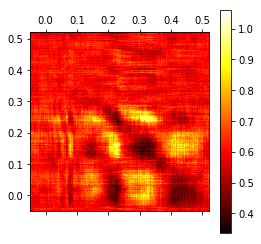

In [90]:
plt.matshow(-np.log10(curpvals[0][0]),extent=timepoints,cmap=plt.cm.hot)

plt.colorbar()

In [84]:
plt.imshow?

Step 3b - Across subjects statistics for patients 